In [ ]:
%matplotlib inline

In [ ]:
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import pandas as pd
import time

In [ ]:
df = pd.read_csv("/content/rus.txt", sep = "\t", header = None)
df

,0,1,2
0,Go.,Марш!,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Go.,Иди.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Go.,Идите.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Hi.,Здравствуйте.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
4,Hi.,Привет!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
...,...,...,...
496054,"At a moment when our economy is growing, our b...","В тот момент, когда наша экономика растёт, наш...",CC-BY 2.0 (France) Attribution: tatoeba.org #3...
496055,"When I was younger, I hated going to weddings....","Когда я была помоложе, я ненавидела ходить на ...",CC-BY 2.0 (France) Attribution: tatoeba.org #2...
496056,Since there are usually multiple websites on a...,"Поскольку сайтов, посвящённых какой-либо теме,...",CC-BY 2.0 (France) Attribution: tatoeba.org #9...
496057,If someone who doesn't know your background sa...,"Если кто-то незнакомый говорит, что вы говорит...",CC-BY 2.0 (France) Attribution: tatoeba.org #9...


In [ ]:
df = df.drop(2, axis = 1)
df

,0,1
0,Go.,Марш!
1,Go.,Иди.
2,Go.,Идите.
3,Hi.,Здравствуйте.
4,Hi.,Привет!
...,...,...
496054,"At a moment when our economy is growing, our b...","В тот момент, когда наша экономика растёт, наш..."
496055,"When I was younger, I hated going to weddings....","Когда я была помоложе, я ненавидела ходить на ..."
496056,Since there are usually multiple websites on a...,"Поскольку сайтов, посвящённых какой-либо теме,..."
496057,If someone who doesn't know your background sa...,"Если кто-то незнакомый говорит, что вы говорит..."


In [ ]:
def normalizeString(s):
    s = s.lower().strip()
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Zа-яА-ЯёЁ.!?]+", r" ", s)
    return s

In [ ]:
df.columns = ["eng", "rus"]
df

,eng,rus
0,Go.,Марш!
1,Go.,Иди.
2,Go.,Идите.
3,Hi.,Здравствуйте.
4,Hi.,Привет!
...,...,...
496054,"At a moment when our economy is growing, our b...","В тот момент, когда наша экономика растёт, наш..."
496055,"When I was younger, I hated going to weddings....","Когда я была помоложе, я ненавидела ходить на ..."
496056,Since there are usually multiple websites on a...,"Поскольку сайтов, посвящённых какой-либо теме,..."
496057,If someone who doesn't know your background sa...,"Если кто-то незнакомый говорит, что вы говорит..."


In [ ]:
df["eng"] = df["eng"].apply(normalizeString)
df["rus"] = df["rus"].apply(normalizeString)
df

,eng,rus
0,go .,марш !
1,go .,иди .
2,go .,идите .
3,hi .,здравствуйте .
4,hi .,привет !
...,...,...
496054,at a moment when our economy is growing our bu...,в тот момент когда наша экономика растёт наши ...
496055,when i was younger i hated going to weddings ....,когда я была помоложе я ненавидела ходить на с...
496056,since there are usually multiple websites on a...,поскольку сайтов посвящённых какой либо теме к...
496057,if someone who doesn t know your background sa...,если кто то незнакомый говорит что вы говорите...


In [ ]:
vocab = {}

In [ ]:
SOS_token = 0
EOS_token = 1

In [ ]:
df["eng_list"] = df["eng"].str.split()
df["rus_list"] = df["rus"].str.split()
df

,eng,rus,eng_list,rus_list
0,go .,марш !,"[go, .]","[марш, !]"
1,go .,иди .,"[go, .]","[иди, .]"
2,go .,идите .,"[go, .]","[идите, .]"
3,hi .,здравствуйте .,"[hi, .]","[здравствуйте, .]"
4,hi .,привет !,"[hi, .]","[привет, !]"
...,...,...,...,...
496054,at a moment when our economy is growing our bu...,в тот момент когда наша экономика растёт наши ...,"[at, a, moment, when, our, economy, is, growin...","[в, тот, момент, когда, наша, экономика, растё..."
496055,when i was younger i hated going to weddings ....,когда я была помоложе я ненавидела ходить на с...,"[when, i, was, younger, i, hated, going, to, w...","[когда, я, была, помоложе, я, ненавидела, ходи..."
496056,since there are usually multiple websites on a...,поскольку сайтов посвящённых какой либо теме к...,"[since, there, are, usually, multiple, website...","[поскольку, сайтов, посвящённых, какой, либо, ..."
496057,if someone who doesn t know your background sa...,если кто то незнакомый говорит что вы говорите...,"[if, someone, who, doesn, t, know, your, backg...","[если, кто, то, незнакомый, говорит, что, вы, ..."


In [ ]:
eng_series = df["eng_list"].apply(pd.Series).stack().reset_index(drop=True)
eng_series

,0
0,go
1,.
2,go
3,.
4,go
...,...
3706121,met
3706122,the
3706123,right
3706124,woman


In [ ]:
eng_set = set(eng_series)
len_eng = len(eng_set) + 2 # с добавлением 0 и 1
len_eng

17261

In [ ]:
rus_series = df["rus_list"].apply(pd.Series).stack().reset_index(drop=True)
rus_series

,0
0,марш
1,!
2,иди
3,.
4,идите
...,...
3111037,не
3111038,встретил
3111039,подходящую
3111040,женщину


In [ ]:
rus_series

,0
0,марш
1,!
2,иди
3,.
4,идите
...,...
3111037,не
3111038,встретил
3111039,подходящую
3111040,женщину


In [ ]:
rus_set = set(rus_series)
len_rus = len(rus_set) + 2 # с добавлением 0 и 1
len_rus

59746

In [ ]:
eng_vocab = {x: y for y, x in enumerate(eng_set, 2)}
eng_vocab

{'chap': 2,
 'f': 3,
 'circulating': 4,
 'ranking': 5,
 'cosmetic': 6,
 'ally': 7,
 'houses': 8,
 'corps': 9,
 'unresolved': 10,
 'tremendous': 11,
 'throws': 12,
 'silent': 13,
 'paid': 14,
 'devastation': 15,
 'rehearsed': 16,
 'kissinger': 17,
 'cafe': 18,
 'aries': 19,
 'meds': 20,
 'protecting': 21,
 'skidded': 22,
 'revolts': 23,
 'synonym': 24,
 'pepsi': 25,
 'soul': 26,
 'everyone': 27,
 'permanent': 28,
 'mont': 29,
 'ghetto': 30,
 'transistor': 31,
 'pathetic': 32,
 'webpage': 33,
 'deflation': 34,
 'bride': 35,
 'shotgun': 36,
 'checkered': 37,
 'went': 38,
 'mass': 39,
 'disgrace': 40,
 'bear': 41,
 'mysteries': 42,
 'mugged': 43,
 'ups': 44,
 'realtor': 45,
 'speller': 46,
 'snuggled': 47,
 'bicycle': 48,
 'envies': 49,
 'moscow': 50,
 'recalled': 51,
 'hazel': 52,
 'leather': 53,
 'seventeen': 54,
 'shirts': 55,
 'rally': 56,
 'solved': 57,
 'walked': 58,
 'stone': 59,
 'decline': 60,
 'smog': 61,
 'drones': 62,
 'verbalizing': 63,
 'dashboard': 64,
 'dreamer': 65,
 'bure

In [ ]:
rus_vocab = {x: y for y, x in enumerate(rus_set, 2)}
rus_vocab

{'коллектива': 2,
 'урон': 3,
 'пописывал': 4,
 'несущую': 5,
 'рань': 6,
 'ваяют': 7,
 'цена': 8,
 'исполнением': 9,
 'тремя': 10,
 'мечтой': 11,
 'забилось': 12,
 'наделали': 13,
 'футболу': 14,
 'важными': 15,
 'подробностей': 16,
 'зарядить': 17,
 'помоев': 18,
 'нищим': 19,
 'закатилась': 20,
 'вылезла': 21,
 'творительный': 22,
 'нарушении': 23,
 'величайшей': 24,
 'полить': 25,
 'исключили': 26,
 'установилась': 27,
 'высадить': 28,
 'сыт': 29,
 'драндулет': 30,
 'приличного': 31,
 'успевать': 32,
 'мощная': 33,
 'прояснила': 34,
 'килте': 35,
 'отказа': 36,
 'машинка': 37,
 'изготовлено': 38,
 'фестивале': 39,
 'лесах': 40,
 'однополые': 41,
 'усиливается': 42,
 'ползать': 43,
 'плюсы': 44,
 'первому': 45,
 'примемся': 46,
 'высох': 47,
 'могущественны': 48,
 'танцами': 49,
 'вилкой': 50,
 'суперзвезда': 51,
 'воздухе': 52,
 'температуру': 53,
 'противоположную': 54,
 'понимаем': 55,
 'обогревался': 56,
 'следуете': 57,
 'погибло': 58,
 'состояла': 59,
 'украдет': 60,
 'легких'

In [ ]:
def encoding(s_list, vocab):
  list_words = []
  for word in s_list:
    list_words.append(vocab[word])
  return list_words

In [ ]:
encoding(["when", "i", "was", "younger", "i", "hated", "going", "shadow"], eng_vocab)

[4457, 17162, 13056, 7102, 17162, 13850, 15024, 6297]

In [ ]:
encoding(["доходы", "задержу", "насыпь"], rus_vocab)

[7883, 2565, 46390]

In [ ]:
df["encripted_eng"] = df["eng_list"].apply(lambda x: encoding(x, eng_vocab))
df

,eng,rus,eng_list,rus_list,encripted_eng
0,go .,марш !,"[go, .]","[марш, !]","[16989, 7812]"
1,go .,иди .,"[go, .]","[иди, .]","[16989, 7812]"
2,go .,идите .,"[go, .]","[идите, .]","[16989, 7812]"
3,hi .,здравствуйте .,"[hi, .]","[здравствуйте, .]","[14749, 7812]"
4,hi .,привет !,"[hi, .]","[привет, !]","[14749, 7812]"
...,...,...,...,...,...
496054,at a moment when our economy is growing our bu...,в тот момент когда наша экономика растёт наши ...,"[at, a, moment, when, our, economy, is, growin...","[в, тот, момент, когда, наша, экономика, растё...","[13260, 13956, 2009, 4457, 16234, 3570, 3468, ..."
496055,when i was younger i hated going to weddings ....,когда я была помоложе я ненавидела ходить на с...,"[when, i, was, younger, i, hated, going, to, w...","[когда, я, была, помоложе, я, ненавидела, ходи...","[4457, 17162, 13056, 7102, 17162, 13850, 15024..."
496056,since there are usually multiple websites on a...,поскольку сайтов посвящённых какой либо теме к...,"[since, there, are, usually, multiple, website...","[поскольку, сайтов, посвящённых, какой, либо, ...","[4786, 13853, 12044, 8743, 11549, 16698, 4906,..."
496057,if someone who doesn t know your background sa...,если кто то незнакомый говорит что вы говорите...,"[if, someone, who, doesn, t, know, your, backg...","[если, кто, то, незнакомый, говорит, что, вы, ...","[12640, 9567, 16467, 4490, 5290, 2426, 5482, 1..."


In [ ]:
df["encripted_rus"] = df["rus_list"].apply(lambda x: encoding(x, rus_vocab))
df

,eng,rus,eng_list,rus_list,encripted_eng,encripted_rus
0,go .,марш !,"[go, .]","[марш, !]","[16989, 7812]","[42855, 34221]"
1,go .,иди .,"[go, .]","[иди, .]","[16989, 7812]","[42773, 36468]"
2,go .,идите .,"[go, .]","[идите, .]","[16989, 7812]","[8536, 36468]"
3,hi .,здравствуйте .,"[hi, .]","[здравствуйте, .]","[14749, 7812]","[17864, 36468]"
4,hi .,привет !,"[hi, .]","[привет, !]","[14749, 7812]","[34847, 34221]"
...,...,...,...,...,...,...
496054,at a moment when our economy is growing our bu...,в тот момент когда наша экономика растёт наши ...,"[at, a, moment, when, our, economy, is, growin...","[в, тот, момент, когда, наша, экономика, растё...","[13260, 13956, 2009, 4457, 16234, 3570, 3468, ...","[10751, 59519, 42273, 20585, 52034, 6288, 2822..."
496055,when i was younger i hated going to weddings ....,когда я была помоложе я ненавидела ходить на с...,"[when, i, was, younger, i, hated, going, to, w...","[когда, я, была, помоложе, я, ненавидела, ходи...","[4457, 17162, 13056, 7102, 17162, 13850, 15024...","[20585, 19816, 56686, 7251, 19816, 51079, 4607..."
496056,since there are usually multiple websites on a...,поскольку сайтов посвящённых какой либо теме к...,"[since, there, are, usually, multiple, website...","[поскольку, сайтов, посвящённых, какой, либо, ...","[4786, 13853, 12044, 8743, 11549, 16698, 4906,...","[34013, 54965, 25276, 46648, 30543, 14983, 552..."
496057,if someone who doesn t know your background sa...,если кто то незнакомый говорит что вы говорите...,"[if, someone, who, doesn, t, know, your, backg...","[если, кто, то, незнакомый, говорит, что, вы, ...","[12640, 9567, 16467, 4490, 5290, 2426, 5482, 1...","[2926, 5729, 20052, 18116, 45882, 13496, 31400..."


In [ ]:
df["encripted_eng"] = df["encripted_eng"].apply(lambda x: x + [EOS_token])
df

,eng,rus,eng_list,rus_list,encripted_eng,encripted_rus
0,go .,марш !,"[go, .]","[марш, !]","[16989, 7812, 1]","[42855, 34221]"
1,go .,иди .,"[go, .]","[иди, .]","[16989, 7812, 1]","[42773, 36468]"
2,go .,идите .,"[go, .]","[идите, .]","[16989, 7812, 1]","[8536, 36468]"
3,hi .,здравствуйте .,"[hi, .]","[здравствуйте, .]","[14749, 7812, 1]","[17864, 36468]"
4,hi .,привет !,"[hi, .]","[привет, !]","[14749, 7812, 1]","[34847, 34221]"
...,...,...,...,...,...,...
496054,at a moment when our economy is growing our bu...,в тот момент когда наша экономика растёт наши ...,"[at, a, moment, when, our, economy, is, growin...","[в, тот, момент, когда, наша, экономика, растё...","[13260, 13956, 2009, 4457, 16234, 3570, 3468, ...","[10751, 59519, 42273, 20585, 52034, 6288, 2822..."
496055,when i was younger i hated going to weddings ....,когда я была помоложе я ненавидела ходить на с...,"[when, i, was, younger, i, hated, going, to, w...","[когда, я, была, помоложе, я, ненавидела, ходи...","[4457, 17162, 13056, 7102, 17162, 13850, 15024...","[20585, 19816, 56686, 7251, 19816, 51079, 4607..."
496056,since there are usually multiple websites on a...,поскольку сайтов посвящённых какой либо теме к...,"[since, there, are, usually, multiple, website...","[поскольку, сайтов, посвящённых, какой, либо, ...","[4786, 13853, 12044, 8743, 11549, 16698, 4906,...","[34013, 54965, 25276, 46648, 30543, 14983, 552..."
496057,if someone who doesn t know your background sa...,если кто то незнакомый говорит что вы говорите...,"[if, someone, who, doesn, t, know, your, backg...","[если, кто, то, незнакомый, говорит, что, вы, ...","[12640, 9567, 16467, 4490, 5290, 2426, 5482, 1...","[2926, 5729, 20052, 18116, 45882, 13496, 31400..."


In [ ]:
df["encripted_rus"] = df["encripted_rus"].apply(lambda x: x + [EOS_token])
df

,eng,rus,eng_list,rus_list,encripted_eng,encripted_rus
0,go .,марш !,"[go, .]","[марш, !]","[16989, 7812, 1]","[42855, 34221, 1]"
1,go .,иди .,"[go, .]","[иди, .]","[16989, 7812, 1]","[42773, 36468, 1]"
2,go .,идите .,"[go, .]","[идите, .]","[16989, 7812, 1]","[8536, 36468, 1]"
3,hi .,здравствуйте .,"[hi, .]","[здравствуйте, .]","[14749, 7812, 1]","[17864, 36468, 1]"
4,hi .,привет !,"[hi, .]","[привет, !]","[14749, 7812, 1]","[34847, 34221, 1]"
...,...,...,...,...,...,...
496054,at a moment when our economy is growing our bu...,в тот момент когда наша экономика растёт наши ...,"[at, a, moment, when, our, economy, is, growin...","[в, тот, момент, когда, наша, экономика, растё...","[13260, 13956, 2009, 4457, 16234, 3570, 3468, ...","[10751, 59519, 42273, 20585, 52034, 6288, 2822..."
496055,when i was younger i hated going to weddings ....,когда я была помоложе я ненавидела ходить на с...,"[when, i, was, younger, i, hated, going, to, w...","[когда, я, была, помоложе, я, ненавидела, ходи...","[4457, 17162, 13056, 7102, 17162, 13850, 15024...","[20585, 19816, 56686, 7251, 19816, 51079, 4607..."
496056,since there are usually multiple websites on a...,поскольку сайтов посвящённых какой либо теме к...,"[since, there, are, usually, multiple, website...","[поскольку, сайтов, посвящённых, какой, либо, ...","[4786, 13853, 12044, 8743, 11549, 16698, 4906,...","[34013, 54965, 25276, 46648, 30543, 14983, 552..."
496057,if someone who doesn t know your background sa...,если кто то незнакомый говорит что вы говорите...,"[if, someone, who, doesn, t, know, your, backg...","[если, кто, то, незнакомый, говорит, что, вы, ...","[12640, 9567, 16467, 4490, 5290, 2426, 5482, 1...","[2926, 5729, 20052, 18116, 45882, 13496, 31400..."


In [ ]:
df["encripted_eng"].apply(len).max()

103

In [ ]:
df["encripted_rus"].apply(len).max()

84

In [ ]:
pairs = []
for index, row in df.iterrows():
  pairs.append((torch.LongTensor(row["encripted_eng"]), torch.LongTensor(row["encripted_rus"])))
pairs

[(tensor([16989,  7812,     1]), tensor([42855, 34221,     1])),
 (tensor([16989,  7812,     1]), tensor([42773, 36468,     1])),
 (tensor([16989,  7812,     1]), tensor([ 8536, 36468,     1])),
 (tensor([14749,  7812,     1]), tensor([17864, 36468,     1])),
 (tensor([14749,  7812,     1]), tensor([34847, 34221,     1])),
 (tensor([14749,  7812,     1]), tensor([45270, 36468,     1])),
 (tensor([14749,  7812,     1]), tensor([29980, 36468,     1])),
 (tensor([14749,  7812,     1]), tensor([34287, 53033, 34221,     1])),
 (tensor([14749,  7812,     1]), tensor([59631, 34221,     1])),
 (tensor([ 124, 5151,    1]), tensor([29250, 34221,     1])),
 (tensor([ 124, 5151,    1]), tensor([ 1968, 34221,     1])),
 (tensor([ 124, 7812,    1]), tensor([29250, 34221,     1])),
 (tensor([ 124, 7812,    1]), tensor([ 1968, 34221,     1])),
 (tensor([16467, 15881,     1]), tensor([ 5729, 43609,     1])),
 (tensor([4533, 5151,    1]), tensor([43086,  4061, 22703, 34221,     1])),
 (tensor([4533, 515

ЭНКОДЕР

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

ДЕКОДЕР

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
teacher_forcing_ratio = 0.5
our_max_length = 103


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, our_max_length):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    encoder_outputs = torch.zeros(our_max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di].unsqueeze(0))
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            loss += criterion(decoder_output, target_tensor[di].unsqueeze(0))
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
import matplotlib.pyplot as plt
#plt.switch_backend('notebook')
import matplotlib
%matplotlib inline
import matplotlib.ticker as ticker


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points);
    ax.set_xlabel("количество иттераций*1000")
    ax.set_ylabel("функция потерь")

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [random.choice(pairs) for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0].to(device)
        target_tensor = training_pair[1].to(device)

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion, our_max_length)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f'iter: {iter}, percent: {(iter / n_iters * 100):.2f}%, loss_avg: {print_loss_avg:.3f}')

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    return plot_losses

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(len_eng, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, len_rus).to(device)

history = trainIters(encoder1, decoder1, 75000, print_every = 500)
history

iter: 500, percent: 0.67%, loss_avg: 6.049
iter: 1000, percent: 1.33%, loss_avg: 5.505
iter: 1500, percent: 2.00%, loss_avg: 5.533
iter: 2000, percent: 2.67%, loss_avg: 5.455
iter: 2500, percent: 3.33%, loss_avg: 5.398
iter: 3000, percent: 4.00%, loss_avg: 5.298
iter: 3500, percent: 4.67%, loss_avg: 5.269
iter: 4000, percent: 5.33%, loss_avg: 5.118
iter: 4500, percent: 6.00%, loss_avg: 5.138
iter: 5000, percent: 6.67%, loss_avg: 5.001
iter: 5500, percent: 7.33%, loss_avg: 5.053
iter: 6000, percent: 8.00%, loss_avg: 4.992
iter: 6500, percent: 8.67%, loss_avg: 4.858
iter: 7000, percent: 9.33%, loss_avg: 4.885
iter: 7500, percent: 10.00%, loss_avg: 4.764
iter: 8000, percent: 10.67%, loss_avg: 4.759
iter: 8500, percent: 11.33%, loss_avg: 4.753
iter: 9000, percent: 12.00%, loss_avg: 4.786
iter: 9500, percent: 12.67%, loss_avg: 4.734
iter: 10000, percent: 13.33%, loss_avg: 4.612
iter: 10500, percent: 14.00%, loss_avg: 4.671
iter: 11000, percent: 14.67%, loss_avg: 4.655
iter: 11500, percent: 

[6.551161182297576,
 6.2942933432096035,
 5.806708207837298,
 5.719759709568344,
 5.873534250320163,
 5.4831875338092315,
 5.502127586794106,
 5.761905508253254,
 5.232286117179767,
 5.545946318341119,
 5.52726175071746,
 5.596966195557412,
 5.413170992228707,
 5.506970528503517,
 5.620830357865336,
 5.540436668310672,
 5.280566361797174,
 5.411326599213988,
 5.542007546724178,
 5.501240662113995,
 5.482839139827919,
 5.565125259105445,
 5.392290959030214,
 5.216546641124263,
 5.335574601860102,
 5.291045663323912,
 5.416024929289523,
 5.293235425858959,
 5.23688488535003,
 5.255283241194061,
 5.231567192638472,
 5.176248429438283,
 5.151631496305485,
 5.492940120186998,
 5.290663975141784,
 5.2227828285532425,
 5.322275469917584,
 5.043702833665572,
 4.781641606198035,
 5.2185139181579805,
 5.104282584548858,
 5.2223813710536096,
 5.206261385039676,
 5.0255467756252115,
 5.130300393030877,
 5.107236415226829,
 4.914561609543577,
 5.086190174443752,
 4.98107127410726,
 4.91793509985659

In [ ]:
len(history)

750

<Figure size 640x480 with 0 Axes>

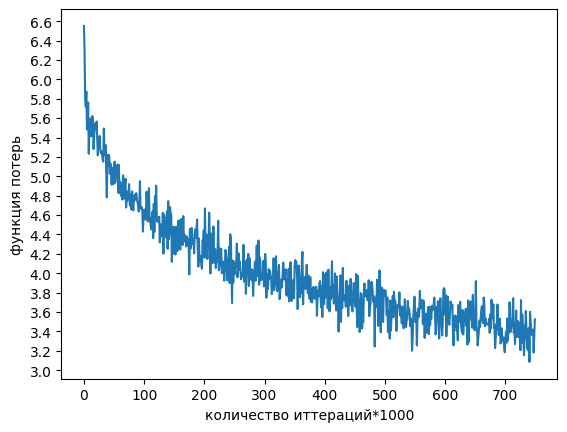

In [ ]:
showPlot(history)

In [ ]:
def tensorFromSentence(sentence, vocab):
  list_words = []
  for word in sentence.split():
    list_words.append(vocab[word])
  list_words.append(EOS_token)
  return torch.tensor(list_words, dtype=torch.long, device=device)

In [ ]:
vocab_reverse_ru = {x: y for y, x in rus_vocab.items()}
vocab_reverse_ru

{2: 'коллектива',
 3: 'урон',
 4: 'пописывал',
 5: 'несущую',
 6: 'рань',
 7: 'ваяют',
 8: 'цена',
 9: 'исполнением',
 10: 'тремя',
 11: 'мечтой',
 12: 'забилось',
 13: 'наделали',
 14: 'футболу',
 15: 'важными',
 16: 'подробностей',
 17: 'зарядить',
 18: 'помоев',
 19: 'нищим',
 20: 'закатилась',
 21: 'вылезла',
 22: 'творительный',
 23: 'нарушении',
 24: 'величайшей',
 25: 'полить',
 26: 'исключили',
 27: 'установилась',
 28: 'высадить',
 29: 'сыт',
 30: 'драндулет',
 31: 'приличного',
 32: 'успевать',
 33: 'мощная',
 34: 'прояснила',
 35: 'килте',
 36: 'отказа',
 37: 'машинка',
 38: 'изготовлено',
 39: 'фестивале',
 40: 'лесах',
 41: 'однополые',
 42: 'усиливается',
 43: 'ползать',
 44: 'плюсы',
 45: 'первому',
 46: 'примемся',
 47: 'высох',
 48: 'могущественны',
 49: 'танцами',
 50: 'вилкой',
 51: 'суперзвезда',
 52: 'воздухе',
 53: 'температуру',
 54: 'противоположную',
 55: 'понимаем',
 56: 'обогревался',
 57: 'следуете',
 58: 'погибло',
 59: 'состояла',
 60: 'украдет',
 61: 'лег

In [ ]:
"""def decoding(string):
  list_words = []
  for char in string.numpy().tolist():
    list_words.append(vocab_reverse_ru[char])
  return " ".join(list_words)"""

In [ ]:
def evaluate(encoder, decoder, sentence, vocab, max_length = 103):
    with torch.no_grad():
        input_tensor = tensorFromSentence(sentence, vocab)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(vocab_reverse_ru[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [ ]:
evaluate(encoder1, decoder1, "are you very crazy dog", eng_vocab)

['ты', 'очень', 'вас', 'за', 'собака', '?', '<EOS>']

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        index = random.randint(0, 496058)
        print('>', df.loc[index, "eng"])
        print('=', df.loc[index, "rus"])
        output_words = evaluate(encoder, decoder, df.loc[index, "eng"], eng_vocab)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [ ]:
evaluateRandomly(encoder1, decoder1)

> you re so nosy .
= ты такой пронырливый .
< ты такая . . <EOS>

> i like talking .
= я люблю поговорить .
< я люблю люблю . <EOS>

> that happened in .
= это случилось в две тысячи тринадцатом .
< это случилось . <EOS>

> how much is the dollar now ?
= сколько сейчас стоит доллар ?
< сколько сейчас стоит ? <EOS>

> were you the one who found it ?
= это вы её нашли ?
< ты это нашёл ? ? <EOS>

> tom s parents were very strict .
= у тома были очень строгие родители .
< тома тома были очень холодно . <EOS>

> tom has decided to stay in australia for another three weeks .
= том решил остаться в австралии ещё на три недели .
< том решил три три три три месяца в три . <EOS>

> don t you have anything to do ?
= вам нечего делать ?
< тебе не надо делать ? ? <EOS>

> i laughed .
= я смеялся .
< я была . <EOS>

> we ve got to hurry .
= нам надо поторапливаться .
< нам надо есть . <EOS>



Происходит потрея контекста. Следует:
а) увеличить размерность скрытого состояния
б) может быть следует заменить gru ячейку на lstm ячейку